In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
import spacy
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None
nlp = spacy.load('en_core_web_sm')

In [2]:
import sklearn.datasets
import re
def clearstring(string):
    string = re.sub('[^A-Za-z ]+', '', string)
    string = string.split(' ')
    string = filter(None, string)
    string = [y.strip() for y in string]
    string = ' '.join(string)
    return string.lower()

def separate_dataset(trainset):
    datastring = []
    datatarget = []
    for i in range(len(trainset.data)):
        data_ = trainset.data[i].split('\n')
        data_ = list(filter(None, data_))
        for n in range(len(data_)):
            data_[n] = clearstring(data_[n])
        datastring += data_
        for n in range(len(data_)):
            datatarget.append(trainset.target[i])
    return datastring, datatarget

In [3]:
import random
trainset = sklearn.datasets.load_files(container_path = 'data', encoding = 'UTF-8')
trainset.data, trainset.target = separate_dataset(trainset)
combined = list(zip(trainset.data, trainset.target))
random.shuffle(combined)
trainset.data[:], trainset.target[:] = zip(*combined)
print (trainset.target_names)
print (len(trainset.data))
print (len(trainset.target))

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
416809
416809


In [4]:
df = pd.DataFrame({'text':trainset.data, 'label':trainset.target})

df["num_words"] = df["text"].apply(lambda x: len(str(x).split()))

df["num_unique_words"] = df["text"].apply(lambda x: len(set(str(x).split())))

df["num_chars"] = df["text"].apply(lambda x: len(str(x)))

df["num_stopwords"] = df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

df["mean_word_len"] = df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [5]:
df_train = df.iloc[:int(df.shape[0] * 0.8),:]
df_test = df.iloc[int(df.shape[0] * 0.8):,:]
df_test = df_test.reset_index()
df_test = df_test.iloc[:,1:]
print(df_train.shape)
print(df_test.shape)

(333447, 7)
(83362, 7)


In [6]:
param = {}
param['objective'] = 'multi:softprob'
param['learning_rate'] = 0.1
param['max_depth'] = 3
param['silent'] = 1
param['subsample'] = 0.8
feature_clf = xgb.XGBClassifier(**param)
train_X = df_train.iloc[:, 2:]
train_Y = df_train.iloc[:, 0]
test_X = df_test.iloc[:, 2:]
test_Y = df_test.iloc[:, 0]
feature_clf.fit(train_X,train_Y, eval_set=[(test_X,test_Y)], 
        eval_metric='mlogloss', early_stopping_rounds=20, verbose=True)

Will train until validation_0 error hasn't decreased in 20 rounds.
[0]	validation_0-mlogloss:1.765842
[1]	validation_0-mlogloss:1.743241
[2]	validation_0-mlogloss:1.723464
[3]	validation_0-mlogloss:1.706175
[4]	validation_0-mlogloss:1.690923
[5]	validation_0-mlogloss:1.677473
[6]	validation_0-mlogloss:1.665609
[7]	validation_0-mlogloss:1.655104
[8]	validation_0-mlogloss:1.645764
[9]	validation_0-mlogloss:1.637449
[10]	validation_0-mlogloss:1.630069
[11]	validation_0-mlogloss:1.623521
[12]	validation_0-mlogloss:1.617647
[13]	validation_0-mlogloss:1.612393
[14]	validation_0-mlogloss:1.607701
[15]	validation_0-mlogloss:1.603477
[16]	validation_0-mlogloss:1.599714
[17]	validation_0-mlogloss:1.596340
[18]	validation_0-mlogloss:1.593318
[19]	validation_0-mlogloss:1.590606
[20]	validation_0-mlogloss:1.588183
[21]	validation_0-mlogloss:1.586002
[22]	validation_0-mlogloss:1.584055
[23]	validation_0-mlogloss:1.582290
[24]	validation_0-mlogloss:1.580728
[25]	validation_0-mlogloss:1.579292
[26]	va

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.8)

In [7]:
from sklearn import metrics
predicted = feature_clf.predict(test_X)
print('accuracy validation set: ', np.mean(predicted == test_Y))
print(metrics.classification_report(test_Y, predicted, target_names = trainset.target_names))

accuracy validation set:  0.347160576762
             precision    recall  f1-score   support

      anger       0.38      0.00      0.00     11246
       fear       0.50      0.00      0.00      9642
        joy       0.35      0.85      0.49     28334
       love       0.00      0.00      0.00      6876
    sadness       0.34      0.20      0.25     24260
   surprise       0.00      0.00      0.00      3004

avg / total       0.33      0.35      0.24     83362



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


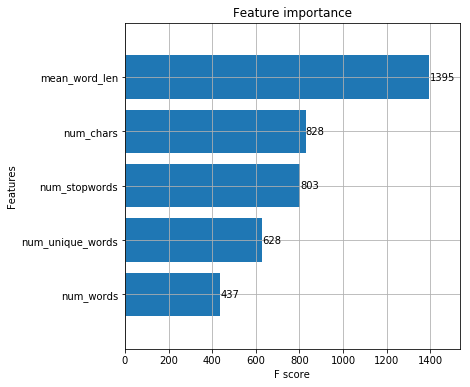

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
xgb.plot_importance(feature_clf, height=0.8, ax=ax)
plt.show()

In [9]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf = tfidf_vec.fit_transform(df.text)
tfidf_train = tfidf_vec.transform(df_train.text)
tfidf_test = tfidf_vec.transform(df_test.text)

In [10]:
model_nb = naive_bayes.MultinomialNB()
model_nb.fit(tfidf_train, train_Y)
predicted = model_nb.predict(tfidf_test)
print(metrics.classification_report(test_Y, predicted, target_names = trainset.target_names))

             precision    recall  f1-score   support

      anger       0.93      0.42      0.58     11246
       fear       0.86      0.32      0.47      9642
        joy       0.63      0.99      0.77     28334
       love       1.00      0.11      0.19      6876
    sadness       0.78      0.95      0.86     24260
   surprise       1.00      0.04      0.07      3004

avg / total       0.79      0.72      0.66     83362



In [13]:
train_tfidf_nb = pd.DataFrame(model_nb.predict_proba(tfidf_train))
test_tfidf_nb = pd.DataFrame(model_nb.predict_proba(tfidf_test))
train_tfidf_nb.columns = ['nb_tfidf_'+i for i in trainset.target_names]
test_tfidf_nb.columns = ['nb_tfidf_'+i for i in trainset.target_names]
df_train = pd.concat([df_train, train_tfidf_nb], axis=1)
df_test = pd.concat([df_test, test_tfidf_nb], axis=1)

In [15]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(tfidf)
train_svd = pd.DataFrame(svd_obj.transform(tfidf_train))
test_svd = pd.DataFrame(svd_obj.transform(tfidf_test))
    
train_svd.columns = ['lsa_'+str(i) for i in range(n_comp)]
test_svd.columns = ['lsa_'+str(i) for i in range(n_comp)]
df_train = pd.concat([df_train, train_svd], axis=1)
df_test = pd.concat([df_test, test_svd], axis=1)

In [16]:
del tfidf, tfidf_train, tfidf_test, train_svd, test_svd
bow_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
bow = bow_vec.fit_transform(df.text)
bow_train = bow_vec.transform(df_train.text)
bow_test = bow_vec.transform(df_test.text)

In [17]:
model_nb = naive_bayes.MultinomialNB()
model_nb.fit(bow_train, train_Y)
predicted = model_nb.predict(bow_test)
print(metrics.classification_report(test_Y, predicted, target_names = trainset.target_names))

             precision    recall  f1-score   support

      anger       0.91      0.80      0.85     11246
       fear       0.84      0.72      0.78      9642
        joy       0.81      0.94      0.87     28334
       love       0.75      0.45      0.56      6876
    sadness       0.84      0.95      0.89     24260
   surprise       0.71      0.23      0.35      3004

avg / total       0.83      0.83      0.82     83362



In [18]:
train_bow_nb = pd.DataFrame(model_nb.predict_proba(bow_train))
test_bow_nb = pd.DataFrame(model_nb.predict_proba(bow_test))
train_bow_nb.columns = ['nb_bow_'+i for i in trainset.target_names]
test_bow_nb.columns = ['nb_bow_'+i for i in trainset.target_names]
df_train = pd.concat([df_train, train_bow_nb], axis=1)
df_test = pd.concat([df_test, test_bow_nb], axis=1)

In [19]:
bow_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
bow = bow_vec.fit_transform(df.text)
bow_train = bow_vec.transform(df_train.text)
bow_test = bow_vec.transform(df_test.text)

In [21]:
model_nb = naive_bayes.MultinomialNB()
model_nb.fit(bow_train, train_Y)
predicted = model_nb.predict(bow_test)
print(metrics.classification_report(test_Y, predicted, target_names = trainset.target_names))

             precision    recall  f1-score   support

      anger       0.87      0.84      0.85     11246
       fear       0.81      0.80      0.80      9642
        joy       0.85      0.88      0.86     28334
       love       0.71      0.67      0.69      6876
    sadness       0.87      0.91      0.89     24260
   surprise       0.74      0.39      0.51      3004

avg / total       0.84      0.84      0.84     83362



In [22]:
train_bow_nb = pd.DataFrame(model_nb.predict_proba(bow_train))
test_bow_nb = pd.DataFrame(model_nb.predict_proba(bow_test))
train_bow_nb.columns = ['nb_bow_char_'+i for i in trainset.target_names]
test_bow_nb.columns = ['nb_bow_char_'+i for i in trainset.target_names]
df_train = pd.concat([df_train, train_bow_nb], axis=1)
df_test = pd.concat([df_test, test_bow_nb], axis=1)

In [23]:
del bow_vec, train_bow_nb, test_bow_nb, bow, bow_train, bow_test

In [25]:
df_train.head()

,label,text,num_words,num_unique_words,num_chars,num_stopwords,mean_word_len,nb_tfidf_anger,nb_tfidf_fear,nb_tfidf_joy,...,nb_bow_joy,nb_bow_love,nb_bow_sadness,nb_bow_surprise,nb_bow_char_anger,nb_bow_char_fear,nb_bow_char_joy,nb_bow_char_love,nb_bow_char_sadness,nb_bow_char_surprise
0,4,ive been feeling a little melancholy,6,6,36,2,5.166667,0.001636,0.001364,0.002907,...,2.332553e-08,1.226894e-10,9.999999e-01,9.731842e-12,1.869089e-66,1.763101e-58,9.618400e-67,1.332998e-70,1.000000e+00,6.914444e-76
1,0,im hella anticipating august and have been fee...,18,18,99,6,4.555556,0.389581,0.034414,0.332815,...,1.641601e-08,1.920556e-13,3.061506e-09,1.786409e-17,1.000000e+00,1.207171e-47,3.787879e-51,4.134736e-50,1.822714e-33,9.973456e-96
2,4,i don t know what s going to happen to us her ...,29,26,144,18,4.000000,0.018487,0.022773,0.188893,...,7.843260e-09,6.481890e-14,1.000000e+00,2.956143e-18,3.042203e-99,7.429498e-88,1.288318e-55,4.238791e-70,1.000000e+00,9.786039e-129
3,1,i think that is it for today other than we are...,33,29,154,21,3.696970,0.045855,0.233471,0.431243,...,1.309941e-04,2.053566e-13,2.902363e-05,1.013273e-16,1.484106e-27,1.000000e+00,2.723717e-08,6.113177e-61,1.736771e-23,1.568926e-138
4,2,i couldnt help but feel amused,6,6,30,2,4.166667,0.002694,0.001398,0.988560,...,9.999946e-01,2.839741e-08,3.657897e-06,3.036534e-09,3.154195e-10,6.082299e-17,1.000000e+00,6.370577e-32,7.923995e-17,2.654663e-17


In [30]:
params_xgd = {
    'min_child_weight': 10.0,
    'max_depth': 7,
    'objective': 'multi:softprob',
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'learning_rate': 0.05,
    'gamma': 0.65,
    'nthread': -1,
    'silent': False,
    'n_estimators': 10000
    }
train_X = df_train.iloc[:,2:]
test_X = df_test.iloc[:,2:]
train_Y = df_train.iloc[:,0]
test_Y = df_test.iloc[:,0]
clf = xgb.XGBClassifier(**params_xgd)
clf.fit(train_X,train_Y, eval_set=[(test_X,test_Y)], 
        eval_metric='mlogloss', early_stopping_rounds=50, verbose=False)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0.65, learning_rate=0.05, max_delta_step=1.8, max_depth=7,
       min_child_weight=10.0, missing=None, n_estimators=10000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=0.8)

In [31]:
predicted = clf.predict(test_X)
print('accuracy validation set: ', np.mean(predicted == test_Y))
print(metrics.classification_report(test_Y, predicted, target_names = trainset.target_names))

accuracy validation set:  0.862527290612
             precision    recall  f1-score   support

      anger       0.89      0.87      0.88     11246
       fear       0.82      0.80      0.81      9642
        joy       0.87      0.91      0.89     28334
       love       0.70      0.64      0.67      6876
    sadness       0.92      0.93      0.93     24260
   surprise       0.63      0.57      0.59      3004

avg / total       0.86      0.86      0.86     83362



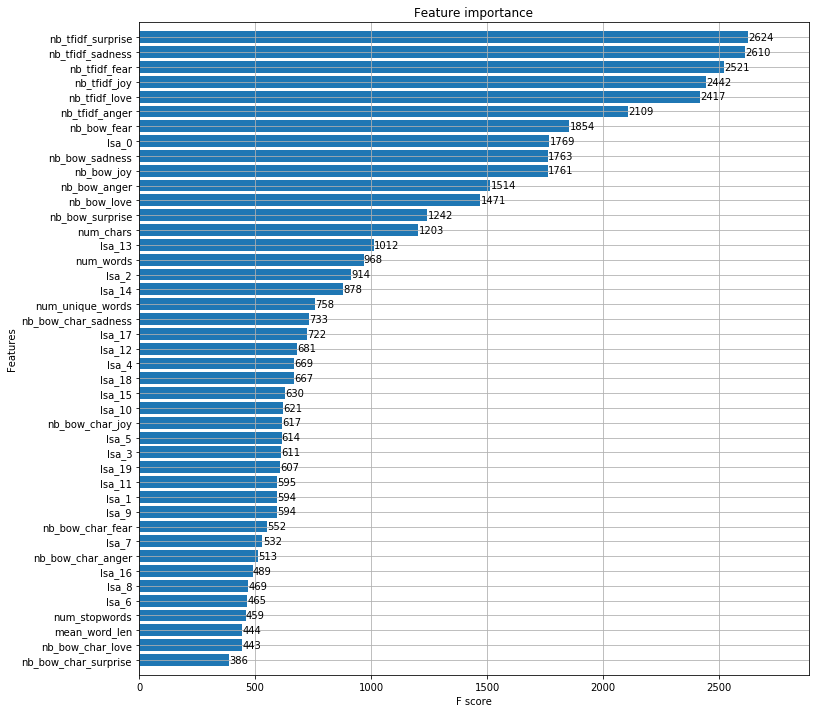

In [32]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(clf, height=0.8, ax=ax)
plt.show()

In [39]:
import os
import psutil
process = psutil.Process(os.getpid())
'this notebook use: ' + str(process.memory_info()[0] / float(2 ** 20)) + ' MB'

'this notebook use: 2554.68359375 MB'